In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import cv2
import imageio.v2 as imageio
import numpy as np
import pandas as pd
from IPython.display import display, Math, Video
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import os
from os import listdir
from os.path import isfile, isdir, join
import time

startInstantTime = time.time()

In [2]:
#Parametros de ejecucion del programa
nombreArchivoInformacion = "InformacionEjercicioRegresion.txt"
nombreArchivoDataset = "DatasetRegresion.csv"
nombreArchivoAnimacion = "Animación del ADALINE"
tasaAprendizaje = 0.001
tiempoPausaAnimacion = 0.001

searchFolderPath = "./Figuras/"
imageFileExtension = ".jpg"
animationFileExtension = ".mp4"
framesPorSegundoAnimacion = 20

colorTextoVerde = (35, 155, 86)
colorTextoRojo = (176, 58, 46)

In [3]:
imageFileExtensionsList = [imageFileExtension]

def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

def getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    filesList.sort(key = lambda file: os.path.getmtime(join(searchFolderPath, file)))
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    return filesList, informativeMessage

def deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    
    for file in filesList:
        os.remove(join(searchFolderPath, file))
    return informativeMessage

def resizeImage(image, width = None, height = None, interpolationTechnique = cv2.INTER_AREA):
    newImageSize = None
    ratioFactor = 1.0
    (imageHeight, imageWidth) = image.shape[:2]
    
    #The ratio factor is computed (only in case to get exactly one of the parameters (width or height) in None), otherwise, the image will be resized without keep its aspect ratio
    if width is None and height is None:
        return image
    if width is None:
        ratioFactor = height / float(imageHeight)
        newImageSize = (int(imageWidth * ratioFactor), height)
    elif height is None:
        ratioFactor = width / float(imageWidth)
        newImageSize = (width, int(imageHeight * ratioFactor))
    else:
        newImageSize = (width, height)
    resizedImage = cv2.resize(image, newImageSize, interpolation = interpolationTechnique)
    return resizedImage

#El ajuste de tamaño comun a las imagenes esta hecho con reescalado al tamaño maximo/minimo o con un slice/recorte al tamaño minimo
def overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList):
    numberImageFilesFound = len(imageFilesList)
    if numberImageFilesFound >= 1:
        maximumWidthForAllImages = -1
        maximumHeightForAllImages = -1
        #minimumWidthForAllImages = float('inf')
        #minimumHeightForAllImages = float('inf')
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImageWidth = originalImage.shape[1]
            originalImageHeight = originalImage.shape[0]
            if originalImageWidth > maximumWidthForAllImages:
                maximumWidthForAllImages = originalImageWidth
            if originalImageHeight > maximumHeightForAllImages:
                maximumHeightForAllImages = originalImageHeight
            #if originalImageWidth < minimumWidthForAllImages:
                #minimumWidthForAllImages = originalImageWidth
            #if originalImageHeight < minimumHeightForAllImages:
                #minimumHeightForAllImages = originalImageHeight
                
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
            originalImage = resizeImage(originalImage, width = maximumWidthForAllImages, height = maximumHeightForAllImages)
            #originalImage = originalImage[0:minimumHeightForAllImages, 0:minimumWidthForAllImages]
            cv2.imwrite(join(searchFolderPath, imageFile), originalImage)
        print("Se han ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(maximumWidthForAllImages) + "x" + str(maximumHeightForAllImages), colorTextoVerde) + " como máximo de ancho por máximo de alto")
        #print("Se han ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(minimumWidthForAllImages) + "x" + str(minimumHeightForAllImages), colorTextoVerde) + " como mínimo de ancho por mínimo de alto")
    else:
        print(printColouredText("La lista dada está vacía", colorTextoRojo))

def createAnimationFromImageFilesAtSomeDirectory(searchFolderPath, imageFileExtensionsList, animationFilename, animationFileExtension, frameRate):
    imageFilesList, informativeMessage = getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList)
    animationFilePath = join(searchFolderPath, animationFilename + animationFileExtension)
    
    writerStream = imageio.get_writer(animationFilePath, fps = frameRate)
    for imageFile in imageFilesList:
        writerStream.append_data(imageio.imread(join(searchFolderPath, imageFile)))
    writerStream.close()
    print("Se ha creado el archivo", printColouredText(animationFilePath, colorTextoVerde))
    return animationFilePath

def obtenerListasCoordenadasRespectivas(listaPuntos, numeroDimensiones):
    diccionarioPuntosPorCoordenadas = {}
    for indice in range(numeroDimensiones):
        diccionarioPuntosPorCoordenadas[indice] = []
    
    for puntoActual in listaPuntos:
        for indice in range(numeroDimensiones):
            coordenadaActual = puntoActual[indice]
            diccionarioPuntosPorCoordenadas[indice].append(coordenadaActual)
    return diccionarioPuntosPorCoordenadas

def crearTextoEcuacionHiperplano(listaCoeficientesHiperplano):
    numeroDimensionesEspacio = len(listaCoeficientesHiperplano) - 1
    diccionarioCoeficientesPrincipalesNoNulos = {}
    for indice in range(numeroDimensionesEspacio):
        if listaCoeficientesHiperplano[indice] != 0.0:
            diccionarioCoeficientesPrincipalesNoNulos[indice] = listaCoeficientesHiperplano[indice]
    
    textoEcuacionHiperplano = ''
    indiceNuevoCoeficienteNoNulo = 0
    if numeroDimensionesEspacio <= 3:
        for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
            if indiceNuevoCoeficienteNoNulo == 0:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'' + chr(indice + 120)
                elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-' + chr(indice + 120)
                else:
                    textoEcuacionHiperplano = r'{}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
            else:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + ' + chr(indice + 120)
                    else:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoEcuacionHiperplano += ' - ' + chr(indice + 120)
                    else:
                        textoEcuacionHiperplano += ' - {}'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
            indiceNuevoCoeficienteNoNulo += 1
    else:
        for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
            if indiceNuevoCoeficienteNoNulo == 0:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'x_{' + str(indice + 1) + '}'
                elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-x_{' + str(indice + 1) + '}'
                else:
                    textoEcuacionHiperplano = r'{}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
            else:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' + {}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoEcuacionHiperplano += ' - x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' - {}x'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
            indiceNuevoCoeficienteNoNulo += 1

    if listaCoeficientesHiperplano[numeroDimensionesEspacio] > 0.0:
        textoEcuacionHiperplano += ' + {}'.format(listaCoeficientesHiperplano[numeroDimensionesEspacio])
    elif listaCoeficientesHiperplano[numeroDimensionesEspacio] < 0.0:
        textoEcuacionHiperplano += ' - {}'.format(-listaCoeficientesHiperplano[numeroDimensionesEspacio])
    textoEcuacionHiperplano += ' = 0'
    return textoEcuacionHiperplano

def crearTextoFuncionLineal(listaCoeficientesFuncionLineal):
    numeroDimensionesEspacio = len(listaCoeficientesFuncionLineal)
    diccionarioCoeficientesPrincipalesNoNulos = {}
    for indice in range(numeroDimensionesEspacio - 1):
        if listaCoeficientesFuncionLineal[indice] != 0.0:
            diccionarioCoeficientesPrincipalesNoNulos[indice] = listaCoeficientesFuncionLineal[indice]
    
    textoEncabezadoFuncion = r'f \left('
    if numeroDimensionesEspacio <= 3:
        for indice in range(numeroDimensionesEspacio - 1):
            if indice == numeroDimensionesEspacio - 2:
                textoEncabezadoFuncion += chr(indice + 120)
            else:
                textoEncabezadoFuncion += chr(indice + 120) + ', '
    else:
        for indice in range(numeroDimensionesEspacio - 1):
            if indice == numeroDimensionesEspacio - 2:
                textoEncabezadoFuncion += r'x_{' + str(indice + 1) + '}'
            else:
                textoEncabezadoFuncion += r'x_{' + str(indice + 1) + '}, '
    textoEncabezadoFuncion += r' \right) = '
    
    textoFuncionLineal = ''
    if listaCoeficientesFuncionLineal[0:(numeroDimensionesEspacio - 1)] == [0.0] * (numeroDimensionesEspacio - 1):
        textoFuncionLineal = '{}'.format(listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
    else:
        indiceNuevoCoeficienteNoNulo = 0
        if numeroDimensionesEspacio <= 3:
            for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
                if indiceNuevoCoeficienteNoNulo == 0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoFuncionLineal = r'' + chr(indice + 120)
                    elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoFuncionLineal = r'-' + chr(indice + 120)
                    else:
                        textoFuncionLineal = r'{}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                            textoFuncionLineal += ' + ' + chr(indice + 120)
                        else:
                            textoFuncionLineal += ' + {}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                    else:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                            textoFuncionLineal += ' - ' + chr(indice + 120)
                        else:
                            textoFuncionLineal += ' - {}'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                indiceNuevoCoeficienteNoNulo += 1
        else:
            for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
                if indiceNuevoCoeficienteNoNulo == 0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoFuncionLineal = r'x_{' + str(indice + 1) + '}'
                    elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoFuncionLineal = r'-x_{' + str(indice + 1) + '}'
                    else:
                        textoFuncionLineal = r'{}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                            textoFuncionLineal += ' + x_{' + str(indice + 1) + '}'
                        else:
                            textoFuncionLineal += ' + {}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                    else:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                            textoFuncionLineal += ' - x_{' + str(indice + 1) + '}'
                        else:
                            textoFuncionLineal += ' - {}x'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                indiceNuevoCoeficienteNoNulo += 1
        
        if listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1] > 0.0:
            textoFuncionLineal += ' + {}'.format(listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
        elif listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1] < 0.0:
            textoFuncionLineal += ' - {}'.format(-listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
    return textoEncabezadoFuncion + textoFuncionLineal

In [4]:
def verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido):
    errorCuadraticoMedio = mean_squared_error(listaValoresSalida, listaValoresSalidaModelo, squared = False)
    return errorCuadraticoMedio < maximoErrorCuadraticoMedioPermitido, errorCuadraticoMedio

def algoritmoADALINE(listaCoeficientesFuncionLinealInicial, listaCoeficientesFuncionLinealMinimoError, listaVectoresAbscisas, listaValoresSalida, maximoErrorCuadraticoMedioPermitido, tasaAprendizaje, numeroDimensiones):
    numeroDimensionesVectoresEntrada = len(listaCoeficientesFuncionLinealInicial) - 1
    listaCoeficientesFuncionLinealActualizada = listaCoeficientesFuncionLinealInicial
    listaValoresSalidaModelo = []
    for punto in listaVectoresAbscisas:
        valorSalidaModelo = np.dot(listaCoeficientesFuncionLinealActualizada[0:numeroDimensionesVectoresEntrada], punto) + listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada]
        listaValoresSalidaModelo.append(valorSalidaModelo)
    listaErroresModelo = np.array(np.abs(listaValoresSalida - listaValoresSalidaModelo))
    
    regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
    listaCoeficientesCorrelacion = [np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaYModelo))]
    listaErroresCuadraticosMedios = [errorCuadraticoMedio]
    listaErroresTipicosTotales = [np.sum(listaErroresModelo)]
    listaErroresTipicosMedios = [np.mean(listaErroresModelo)]
    
    numeroPasos = 0
    if regresionCompletada == False:
        mensajeConfirmacion = deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
        print(printColouredText(mensajeConfirmacion, colorTextoRojo))
        if numeroDimensiones == 2:
            plt.ion()
            while regresionCompletada == False:
                plt.clf()
                
                indicePuntoActual = 0
                for abscisasPunto in listaVectoresAbscisas:
                    valorPunto = np.dot(listaCoeficientesFuncionLinealActualizada[0:numeroDimensionesVectoresEntrada], abscisasPunto) + listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada]
                    error = listaValoresSalida[indicePuntoActual] - valorPunto
                    for indice in range(numeroDimensionesVectoresEntrada):
                        listaCoeficientesFuncionLinealActualizada[indice] += tasaAprendizaje * error * abscisasPunto[indice]
                    listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada] += tasaAprendizaje * error
                    indicePuntoActual += 1
                
                """
                for punto in listaPuntosMuestra:
                    abscisasPunto = punto[0:(numeroDimensiones - 1)]
                    valorPunto = np.dot(listaCoeficientesHiperplanoBase[0:(numeroDimensiones - 1)], abscisasPunto) + listaCoeficientesHiperplanoBase[numeroDimensiones - 1]
                    error = punto[numeroDimensiones - 1] - valorPunto

                    for indice in range(numeroDimensiones - 1):
                        listaCoeficientesHiperplanoBase[indice] += tasaAprendizaje * error * punto[indice]
                    listaCoeficientesHiperplanoBase[numeroDimensiones - 1] += tasaAprendizaje * error
                """
                
                listaValoresSalidaModelo = []
                for punto in listaVectoresAbscisas:
                    valorSalidaModelo = np.dot(listaCoeficientesFuncionLinealActualizada[0:numeroDimensionesVectoresEntrada], punto) + listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada]
                    listaValoresSalidaModelo.append(valorSalidaModelo)
                listaErroresModelo = np.array(np.abs(listaValoresSalida - listaValoresSalidaModelo))
                
                regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
                coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaYModelo))
                errorTipicoTotal = np.sum(listaErroresModelo)
                errorTipicoMedio = np.mean(listaErroresModelo)
                listaCoeficientesCorrelacion.append(coeficienteCorrelacion)
                listaErroresCuadraticosMedios.append(errorCuadraticoMedio)
                listaErroresTipicosTotales.append(errorTipicoTotal)
                listaErroresTipicosMedios.append(errorTipicoMedio)
                print("Error en la iteracion " + str(numeroPasos) + " = " + str(errorCuadraticoMedio))




                listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaYHiperplanoBase = [listaCoeficientesHiperplanoBase[0] * valorX + listaCoeficientesHiperplanoBase[1] for valorX in listaValoresCoordenadaXHiperplanoBase]

                plt.plot(valoresCoordenadasXPuntosMuestra, valoresCoordenadasYPuntosMuestra, 'ro', label = "Puntos de Muestra")
                plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'b-', label = "Modelo de Regresión Lineal Propuesto Inicialmente (Algoritmo Adaline)")
                plt.legend(loc = 'upper left')
                plt.xlabel("Eje X")
                plt.ylabel("Eje Y")
                plt.title("Visualización de la Recta de Regresión que proporciona el Algoritmo Adaline")
                plt.grid(True)

                numeroPasos += 1
                if errorTotal <= errorMinimo:
                    print("Fue(ron) necesario(s)", numeroPasos, "paso(s) para obtener un plano de regresion")
                    #print("El plano de regresion que proporciona el algoritmo es z = " + str(w1) + "x + " + str(w2) + "y + " + str(b))
                    break

                plt.pause(tiempoPausaAnimacion)
            plt.ioff()
            plt.show()
        elif numeroDimensiones == 3:
            currentFigure = plt.figure(num = 2, figsize = (9, 8))
            ax = currentFigure.gca(projection = '3d')
            ax.view_init(elev = 8, azim = 10)
            plt.ion()
            while regresionCompletada == False:
                ax.cla()
                
                indicePuntoActual = 0
                for abscisasPunto in listaVectoresAbscisas:
                    valorPunto = np.dot(listaCoeficientesFuncionLinealActualizada[0:numeroDimensionesVectoresEntrada], abscisasPunto) + listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada]
                    error = listaValoresSalida[indicePuntoActual] - valorPunto
                    for indice in range(numeroDimensionesVectoresEntrada):
                        listaCoeficientesFuncionLinealActualizada[indice] += tasaAprendizaje * error * abscisasPunto[indice]
                    listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada] += tasaAprendizaje * error
                    indicePuntoActual += 1
                
                """
                for punto in listaPuntosMuestra:
                    abscisasPunto = punto[0:(numeroDimensiones - 1)]
                    valorPunto = np.dot(listaCoeficientesHiperplanoBase[0:(numeroDimensiones - 1)], abscisasPunto) + listaCoeficientesHiperplanoBase[numeroDimensiones - 1]
                    error = punto[numeroDimensiones - 1] - valorPunto
                    errorTotal += np.abs(error)

                    for indice in range(numeroDimensiones - 1):
                        listaCoeficientesHiperplanoBase[indice] += tasaAprendizaje * error * punto[indice]
                    listaCoeficientesHiperplanoBase[numeroDimensiones - 1] += tasaAprendizaje * error

                errorTotal = errorTotal / len(listaPuntosMuestra)
                print("Error en la iteracion " + str(numeroPasos) + " = " + str(errorTotal))
                """
                
                
                listaValoresSalidaModelo = []
                for punto in listaVectoresAbscisas:
                    valorSalidaModelo = np.dot(listaCoeficientesFuncionLinealActualizada[0:numeroDimensionesVectoresEntrada], punto) + listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada]
                    listaValoresSalidaModelo.append(valorSalidaModelo)
                listaErroresModelo = np.array(np.abs(listaValoresSalida - listaValoresSalidaModelo))

                regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
                coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaYModelo))
                errorTipicoTotal = np.sum(listaErroresModelo)
                errorTipicoMedio = np.mean(listaErroresModelo)
                listaCoeficientesCorrelacion.append(coeficienteCorrelacion)
                listaErroresCuadraticosMedios.append(errorCuadraticoMedio)
                listaErroresTipicosTotales.append(errorTipicoTotal)
                listaErroresTipicosMedios.append(errorTipicoMedio)
                print("Error en la iteracion " + str(numeroPasos) + " = " + str(errorCuadraticoMedio))
                
                
                
                
                
                
                valoresCoordenadasZPuntos = listaPuntosPorCoordenadasRespectivas[2]
                minimoEjeZ = np.min(valoresCoordenadasZPuntos) - 1
                maximoEjeZ = np.max(valoresCoordenadasZPuntos) + 1

                listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
                listaValoresCoordenadaZHiperplanoBase = listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 1]
                listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaYHiperplanoMinimoError = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError = np.meshgrid(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError)
                listaValoresCoordenadaZHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]

                currentFigure = plt.figure(num = 1, figsize = (9, 8))
                ax = currentFigure.gca(projection = '3d')
                ax.view_init(elev = 8, azim = 10)
                ax.scatter(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, valoresCoordenadasZPuntos, c = 'r', marker = 'o')
                etiquetaLeyendaPuntos = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
                ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'b', alpha = 0.35)
                etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'b')
                ax.plot_surface(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, listaValoresCoordenadaZHiperplanoMinimoError, color = 'g', alpha = 0.35)
                etiquetaLeyendaPlanoMinimoError = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
                ax.set_xlabel("Eje X")
                ax.set_ylabel("Eje Y")
                ax.set_zlabel("Eje Z")
                ax.set_title("Visualización del Plano de Regresión que proporciona el Algoritmo Adaline")
                ax.legend([etiquetaLeyendaPuntos, etiquetaLeyendaPlano, etiquetaLeyendaPlanoMinimoError], ["Puntos de Muestra", "Plano de Regresión Lineal Propuesto Inicialmente (Algoritmo Adaline)", "Plano de Regresión Lineal de Mínimo Error"], numpoints = 1)
                plt.tight_layout()
                plt.show()
                
                
                
                
                
                

                #listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
                #listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
                #listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
                #listaValoresCoordenadaZHiperplanoBase = listaCoeficientesHiperplanoBase[0] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[1] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesHiperplanoBase[2]

                #ax.scatter(valoresCoordenadasXPuntosMuestra, valoresCoordenadasYPuntosMuestra, valoresCoordenadasZPuntosMuestra, c = 'r', marker = 'o')
                #etiquetaLeyendaPuntosMuestra = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
                #ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'b', alpha = 0.35)
                #etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'b')
                #ax.set_xlabel("Eje X")
                #ax.set_ylabel("Eje Y")
                #ax.set_zlabel("Eje Z")
                #ax.set_title("Visualización del Plano de Regresión que proporciona el Algoritmo Adaline")
                #ax.legend([etiquetaLeyendaPuntosMuestra, etiquetaLeyendaPlano], ["Puntos de Muestra", "Modelo de Regresión Lineal Propuesto Inicialmente (Algoritmo Adaline)"], numpoints = 1)
                #plt.tight_layout()
                
                regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)

                numeroPasos += 1
                #if errorTotal <= errorMinimo:
                #    print("Fue(ron) necesario(s)", numeroPasos, "paso(s) para obtener un plano de regresion")
                #    #print("El plano de regresion que proporciona el algoritmo es z = " + str(w1) + "x + " + str(w2) + "y + " + str(b))
                #    break

                plt.pause(tiempoPausaAnimacion)
            plt.ioff()
            plt.show()
    return listaCoeficientesFuncionLinealActualizada, listaCoeficientesCorrelacion, listaErroresCuadraticosMedios, listaErroresTipicosTotales, listaErroresTipicosMedios

In [5]:
numeroDimensiones = None
listaCoeficientesFuncionLinealBase = []
etiquetaCoordenadaPuntos = None
nombreColumnaValorFuncion = None

inputStream = open(nombreArchivoInformacion, "r")
lineasTextoArchivo = inputStream.readlines()
for numeroLineaActual in range(len(lineasTextoArchivo)):
    if numeroLineaActual == 0:
        numeroDimensiones = int(lineasTextoArchivo[numeroLineaActual].strip())
    elif numeroLineaActual == 1:
        lineaTextoActual = lineasTextoArchivo[numeroLineaActual].strip()
        lineaTextoActual = lineaTextoActual[1:(len(lineaTextoActual) - 1)]
        datosCoeficientesHiperplano = lineaTextoActual.split(", ")
        for coeficiente in datosCoeficientesHiperplano:
            listaCoeficientesFuncionLinealBase.append(float(coeficiente))
    elif numeroLineaActual == 2:
        etiquetaCoordenadaPuntos = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 3:
        nombreColumnaValorFuncion = lineasTextoArchivo[numeroLineaActual].strip()
inputStream.close()

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoInformacion, colorTextoVerde))
print("Se está trabajando sobre", printColouredText(str(numeroDimensiones) + " dimension(es)", colorTextoVerde))
print("Los coeficientes del hiperplano (Función lineal) sobre el cual se generó el dataset de puntos para regresión son:", printColouredText(str(listaCoeficientesFuncionLinealBase), colorTextoRojo))

Se ha extraído la información del archivo InformacionEjercicioRegresion.txt
Se está trabajando sobre 3 dimension(es)
Los coeficientes del hiperplano (Función lineal) sobre el cual se generó el dataset de puntos para regresión son: [-2.9518965737290266, 5.158182648635917, 8.531018655731607]


In [6]:
datasetFile = pd.read_csv(nombreArchivoDataset)

listaAbscisasPuntosMuestra = []
listaPuntosMuestra = []
for indicefilaActual, filaActual in datasetFile.iterrows():
    puntoActual = []
    for indice in range(numeroDimensiones - 1):
        nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
        puntoActual.append(filaActual[nombreColumnaActual])
    listaAbscisasPuntosMuestra.append(puntoActual)
    valorFuncionPuntoActual = filaActual[nombreColumnaValorFuncion]
    listaPuntosMuestra.append(puntoActual + [valorFuncionPuntoActual])

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoDataset, colorTextoVerde))
print("Se tiene un total de", printColouredText(str(len(listaPuntosMuestra)) + " punto(s)", colorTextoVerde))

Se ha extraído la información del archivo DatasetRegresion.csv
Se tiene un total de 2500 punto(s)


In [7]:
#Esta parte se puede comentar para que no se proponga inicialmente un hiperplano de coeficientes aleatorios sino para que el hiperplano propuesto inicialmente separe perfectamente las muestras de las 2 clases y por lo tanto no se realizaran iteraciones del algoritmo del perceptron simple
listaCoeficientesFuncionLinealBase = list(np.random.uniform(low = -10.0, high = 10.0, size = numeroDimensiones))

listaCoeficientesHiperplanoRegresionBase = []
for indice in range(numeroDimensiones):
    if indice == numeroDimensiones - 1:
        listaCoeficientesHiperplanoRegresionBase.append(1.0)
    listaCoeficientesHiperplanoRegresionBase.append(-listaCoeficientesFuncionLinealBase[indice])
textoEcuacionHiperplanoRegresionBase = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoRegresionBase)
if numeroDimensiones == 2:
    print("La recta propuesta inicialmente para ejecutar el algoritmo ADALINE, está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoRegresionBase))

textoFuncionLinealBase = crearTextoFuncionLineal(listaCoeficientesFuncionLinealBase)
if numeroDimensiones == 2:
    print("Como función, la recta propuesta inicialmente para ejecutar el algoritmo ADALINE, es:")
elif numeroDimensiones == 3:
    print("Como función, el plano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:")
elif numeroDimensiones >= 4:
    print("Como función, el hiperplano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:")
display(Math(textoFuncionLinealBase))

El plano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:


<IPython.core.display.Math object>

Como función, el plano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:


<IPython.core.display.Math object>

In [8]:
listaVariablesEntrada = []
for indice in range(numeroDimensiones - 1):
    nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
    listaVariablesEntrada.append(nombreColumnaActual)

#Se toman las variables necesarias del conjunto de datos y se realiza el entrenamiento del modelo de regresion lineal
listaValoresEntradaX = datasetFile[listaVariablesEntrada]
listaValoresSalidaY = datasetFile[nombreColumnaValorFuncion]
modeladorRegresionLineal = linear_model.LinearRegression()
modeladorRegresionLineal.fit(listaValoresEntradaX, listaValoresSalidaY)
listaValoresSalidaYModelo = modeladorRegresionLineal.predict(listaValoresEntradaX)

In [9]:
#Se muestran los resultados del modelo de regresion lineal junto al error obtenido en una tabla comparativa de resultados
listaErroresModelo = np.abs(np.array(listaValoresSalidaY.tolist()) - np.array(listaValoresSalidaYModelo.tolist()))

informacionTablaResultados = {}
for indice in range(numeroDimensiones - 1):
    nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
    informacionTablaResultados[nombreColumnaActual] = datasetFile[nombreColumnaActual].tolist()
informacionTablaResultados[nombreColumnaValorFuncion + ' (Real)'] = listaValoresSalidaY.tolist()
informacionTablaResultados[nombreColumnaValorFuncion + ' (Modelo)'] = listaValoresSalidaYModelo.tolist()
informacionTablaResultados['Error'] = listaErroresModelo
display(pd.DataFrame(informacionTablaResultados))

,Coordenada $x_{1}$,Coordenada $x_{2}$,Valor de la Función (Real),Valor de la Función (Modelo),Error
0,2.178046,17.687657,130.142564,91.628859,38.513705
1,-3.793046,12.118031,118.972190,80.886257,38.085933
2,-17.160484,5.771761,118.972956,88.164748,30.808208
3,-17.446461,-15.138319,13.415466,-17.979979,31.395445
4,15.482258,-1.642333,-27.320291,-46.844923,19.524632
...,...,...,...,...,...
2495,9.385773,13.110046,23.240804,46.771399,23.530595
2496,-2.377120,-15.054398,-96.327086,-62.363479,33.963607
2497,-15.504425,1.584952,46.052094,61.816437,15.764343
2498,-19.835076,-2.208604,8.118534,55.283532,47.164998


In [10]:
#Se muestra la informacion de desempeño del modelo de regresion lineal
coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaYModelo))
minimoErrorCuadraticoMedio = mean_squared_error(listaValoresSalidaY, listaValoresSalidaYModelo, squared = False)
minimoErrorTipicoTotal = np.sum(listaErroresModelo)
minimoErrorTipicoMedio = np.mean(listaErroresModelo)
print("El coeficiente de correlación del modelo de mínimo error es:", printColouredText(str(coeficienteCorrelacion), colorTextoVerde))
print("El error típico total del modelo de mínimo error es:", printColouredText(str(minimoErrorTipicoTotal), colorTextoRojo))
print("El error típico medio del modelo de mínimo error es:", printColouredText(str(minimoErrorTipicoMedio), colorTextoRojo))
print("El error cuadrático medio del modelo de mínimo error es:", printColouredText(str(minimoErrorCuadraticoMedio), colorTextoRojo))

#Se indica la formula matematica del modelo (funcion lineal) que relaciona las variables de entrada con la variable de salida
listaCoeficientesFuncionLinealMinimoError = list(np.array(modeladorRegresionLineal.coef_)) + list([modeladorRegresionLineal.intercept_])

El coeficiente de correlación del modelo de mínimo error es: 0.9214514962776247
El error típico total del modelo de mínimo error es: 62811.9127285188
El error típico medio del modelo de mínimo error es: 25.12476509140752
El error cuadrático medio del modelo de mínimo error es: 28.986508976516536


In [11]:
listaCoeficientesHiperplanoRegresionMinimoError = []
for indice in range(numeroDimensiones):
    if indice == numeroDimensiones - 1:
        listaCoeficientesHiperplanoRegresionMinimoError.append(1.0)
    listaCoeficientesHiperplanoRegresionMinimoError.append(-listaCoeficientesFuncionLinealMinimoError[indice])
textoEcuacionHiperplanoRegresionMinimoError = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoRegresionMinimoError)
if numeroDimensiones == 2:
    print("El modelo de regresión (que da la recta de mínimo error) está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El modelo de regresión (que da el plano de mínimo error) está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El modelo de regresión (que da el hiperplano de mínimo error) está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoRegresionMinimoError))

textoFuncionLinealRegresionMinimoError = crearTextoFuncionLineal(listaCoeficientesFuncionLinealMinimoError)
if numeroDimensiones == 2:
    print("Como función, el modelo de regresión (que da la recta de mínimo error) es:")
elif numeroDimensiones == 3:
    print("Como función, el modelo de regresión (que da el plano de mínimo error) es:")
elif numeroDimensiones >= 4:
    print("Como función, el modelo de regresión (que da el hiperplano de mínimo error) es:")
display(Math(textoFuncionLinealRegresionMinimoError))

El modelo de regresión (que da el plano de mínimo error) está dado por la ecuación:


<IPython.core.display.Math object>

Como función, el modelo de regresión (que da el plano de mínimo error) es:


<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


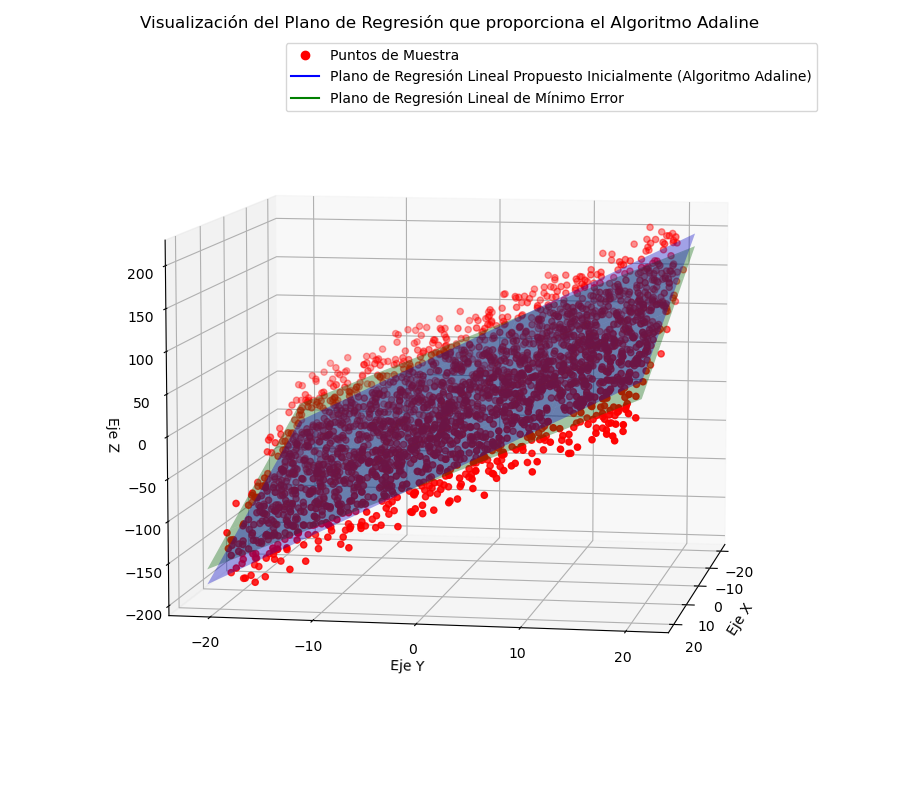

/tmp/ipykernel_5137/1187192549.py:46: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [14]:
%matplotlib notebook

listaPuntosPorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(listaPuntosMuestra, numeroDimensiones)
valoresCoordenadasXPuntos = listaPuntosPorCoordenadasRespectivas[0]
valoresCoordenadasYPuntos = listaPuntosPorCoordenadasRespectivas[1]
valoresCoordenadasZPuntos = None
minimoEjeX = np.min(valoresCoordenadasXPuntos) - 1
maximoEjeX = np.max(valoresCoordenadasXPuntos) + 1
minimoEjeY = np.min(valoresCoordenadasYPuntos) - 1
maximoEjeY = np.max(valoresCoordenadasYPuntos) + 1
minimoEjeZ = None
maximoEjeZ = None

numeroMuestrasHiperplanoRegresion = 10
if numeroDimensiones == 2:
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoBase = listaCoeficientesFuncionLinealBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 1]
    listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
    
    plt.figure(num = 1, figsize = (9, 8))
    plt.plot(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, 'ro', label = "Puntos de Muestra")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'b-', label = "Recta de Regresión Lineal Propuesto Inicialmente (Algoritmo Adaline)")
    plt.plot(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, 'g-', label = "Recta de Regresión Lineal de Mínimo Error")
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Regresión que proporciona el Algoritmo Adaline")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    valoresCoordenadasZPuntos = listaPuntosPorCoordenadasRespectivas[2]
    minimoEjeZ = np.min(valoresCoordenadasZPuntos) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntos) + 1
    
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
    listaValoresCoordenadaZHiperplanoBase = listaCoeficientesFuncionLinealBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 1]
    listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoMinimoError = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError = np.meshgrid(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError)
    listaValoresCoordenadaZHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
    
    currentFigure = plt.figure(num = 1, figsize = (9, 8))
    ax = currentFigure.gca(projection = '3d')
    ax.view_init(elev = 8, azim = 10)
    ax.scatter(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, valoresCoordenadasZPuntos, c = 'r', marker = 'o')
    etiquetaLeyendaPuntos = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'b', alpha = 0.35)
    etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'b')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, listaValoresCoordenadaZHiperplanoMinimoError, color = 'g', alpha = 0.35)
    etiquetaLeyendaPlanoMinimoError = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Regresión que proporciona e            l Algoritmo Adaline")
    ax.legend([etiquetaLeyendaPuntos, etiquetaLeyendaPlano, etiquetaLeyendaPlanoMinimoError], ["Puntos de Muestra", "Plano de Regresión Lineal Propuesto Inicialmente (Algoritmo Adaline)", "Plano de Regresión Lineal de Mínimo Error"], numpoints = 1)
    plt.tight_layout()
    plt.show()

No hay archivos con extensión ['.jpg'] para eliminar, en la carpeta ./Figuras/


<IPython.core.display.Javascript object>


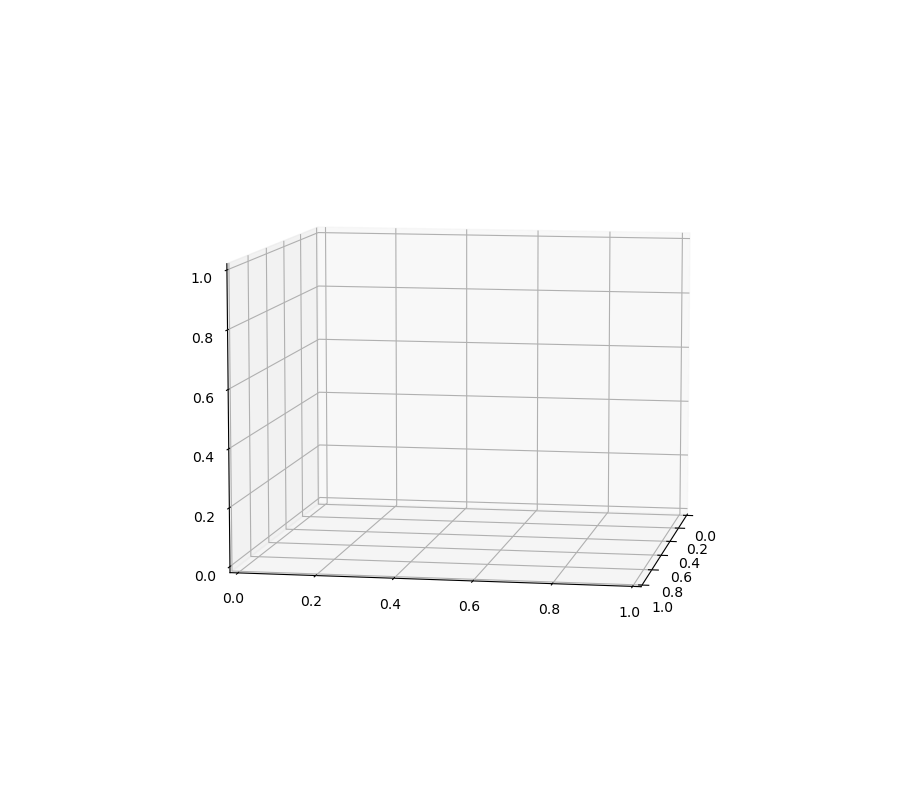

Error en la iteracion 0 = 30.82751754750954


/tmp/ipykernel_5137/3197198217.py:90: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')
/tmp/ipykernel_5137/3197198217.py:156: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [13]:
errorCuadraticoMedioPermitido = 1.25 * minimoErrorCuadraticoMedio + 2.5

listaCoeficientesFuncionLinealEstimacion, listaCoeficientesCorrelacion, listaErroresCuadraticosMedios, listaErroresTipicosTotales, listaErroresTipicosMedios = algoritmoADALINE(listaCoeficientesFuncionLinealBase, listaCoeficientesFuncionLinealMinimoError, listaAbscisasPuntosMuestra, np.array(listaValoresSalidaY.tolist()), errorCuadraticoMedioPermitido, tasaAprendizaje, numeroDimensiones)